<a href="https://colab.research.google.com/github/revanthjavvaji/SE20UARI071_Assignments/blob/main/3_Fine_Tune_ResNet_model_to_classify_cat_and_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the "Cats vs Dogs" dataset from TensorFlow Datasets
builder = tfds.builder("cats_vs_dogs")
builder.download_and_prepare()

# Access the dataset splits (train, validation, test)
train_data = builder.as_dataset(split="train")

# Iterate through the dataset
for example in train_data.take(5):  # Print the first 5 examples
    image = example["image"]
    label = example["label"]
    filename = example["image/filename"]
    print(f"Label: {label.numpy()}, Filename: {filename.numpy()}")

# Optionally, you can load the test split in a similar way
# test_data = builder.as_dataset(split="test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteQQB7YT/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Label: 1, Filename: b'PetImages/Dog/10396.jpg'
Label: 1, Filename: b'PetImages/Dog/4077.jpg'
Label: 1, Filename: b'PetImages/Dog/10497.jpg'
Label: 0, Filename: b'PetImages/Cat/2763.jpg'
Label: 1, Filename: b'PetImages/Dog/11257.jpg'


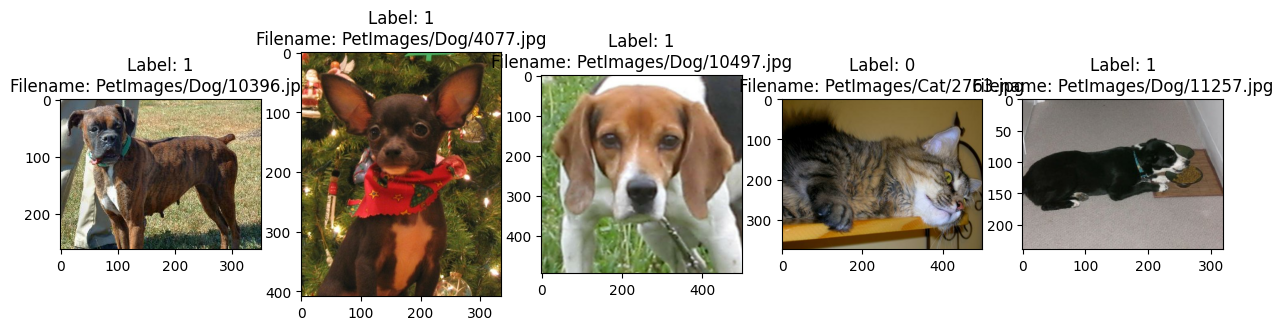

In [3]:
import matplotlib.pyplot as plt

# Load the dataset and get a few examples
train_data = builder.as_dataset(split="train")
sample_images = list(train_data.take(5))  # Change the number to the desired number of images to display

# Display the sample images
fig, axs = plt.subplots(1, len(sample_images), figsize=(15, 5))

for i, example in enumerate(sample_images):
    image = example["image"].numpy()
    label = example["label"].numpy()
    filename = example["image/filename"].numpy().decode()

    axs[i].imshow(image)
    axs[i].set_title(f"Label: {label}\nFilename: {filename}")

plt.show()

In [4]:
# Prepare the data for training and testing
def preprocess_data(data):
    def _preprocess(example):
        image = tf.image.resize(example["image"], (224, 224))
        image = tf.image.convert_image_dtype(image, tf.float32)
        label = tf.one_hot(example["label"], depth=2)
        return image, label

    data = data.map(_preprocess)
    data = data.batch(32)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [5]:
train_size = int(0.8 * builder.info.splits["train"].num_examples)
test_size = builder.info.splits["train"].num_examples - train_size

train_data = train_data.take(train_size)
test_data = train_data.skip(train_size).take(test_size)

In [6]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Load the ResNet50 model

In [7]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


# Freeze the weights of the convolutional layers

In [8]:
for layer in resnet.layers:
    layer.trainable = False

# Add a new classifier part of the model

In [9]:
# Add a new classifier part of the model
x = Flatten()(resnet.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # Two classes: cat and dog

In [10]:
# Create the new model
model = Model(inputs=resnet.input, outputs=output)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model

In [ ]:
history = model.fit(train_data, validation_data=test_data, epochs=11,verbose=0)
for epoch in range(0, 30, 10):
    train_accuracy = history.history['accuracy'][epoch]
    val_accuracy = history.history['val_accuracy'][epoch]
    print(f'Epoch {epoch + 1} - Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the model

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)